# Possible thesis topic: Case study of a blocking in terms of EDA
## TODO:
- select case: 01-05-2017 06:00 UTC - 14-05-2017 00:00 UTC North Atlantic
- plot Var(EDA) gh500 field
- prepare syn_cond plot
    - obtain relevant ERA5 data
- investigate other fields
- check out uncertainty plots on ecmwf page (https://intraplots.ecmwf.int/packages/diagnostics/)

In [52]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


## Get the spread

In [2]:
target_year <- 2017
data_path <- "/net/scratch/schoelleh96/WP2/WP2.2a/ens_data/"
file_name <- paste0("spread_", target_year, ".nc")
library(ncdf4)


In [3]:
nc <- nc_open(paste0(data_path, file_name))
z_data <- ncvar_get(nc, "z")

lat <- ncvar_get(nc, "latitude")
lon <- ncvar_get(nc, "longitude")
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))


## Get the Control Z

In [4]:
# Open the file
nc <- nc_open(paste0(data_path, "data.nc"))

# Identify the index for number == 0
num <- ncvar_get(nc, "number")
number_idx <- which(num == 0)
if (length(number_idx) == 0) {
    stop("No index found where number equals 0.")
}
# Use the first occurrence (modify if needed)
number_idx <- number_idx[1]
# Find indices for the desired year
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))
time_idx <- which(format(time_whole, "%Y") == target_year)
if (length(time_idx) == 0) {
    stop("No time indices found for the specified year.")
}
start_vec <- c(1, 1, min(time_idx), number_idx)
count_vec <- c(-1, -1, length(time_idx), 1)
z_control <- ncvar_get(nc, "z", start = start_vec, count = count_vec)

nc_close(nc)

str(z_control)


 num [1:241, 1:141, 1:365] 51021 51021 51021 51021 51021 ...


In [5]:
add_contours <- function(data, var_name, color = "red", linewidth = 0.5) {
    # Convert to sf and then project to CRS
    contour_sf <- st_as_sf(data, coords = c("lon", "lat"), crs = 4326) %>%
        st_transform(CRS) %>%
        cbind(st_coordinates(.)) %>% # adds X and Y columns
        as.data.frame()

    # Add contour layer to the existing ggplot
    geom_contour(
        data = contour_sf, aes(x = X, y = Y, z = .data[[var_name]]),
        color = color, linewidth = linewidth
    )
}


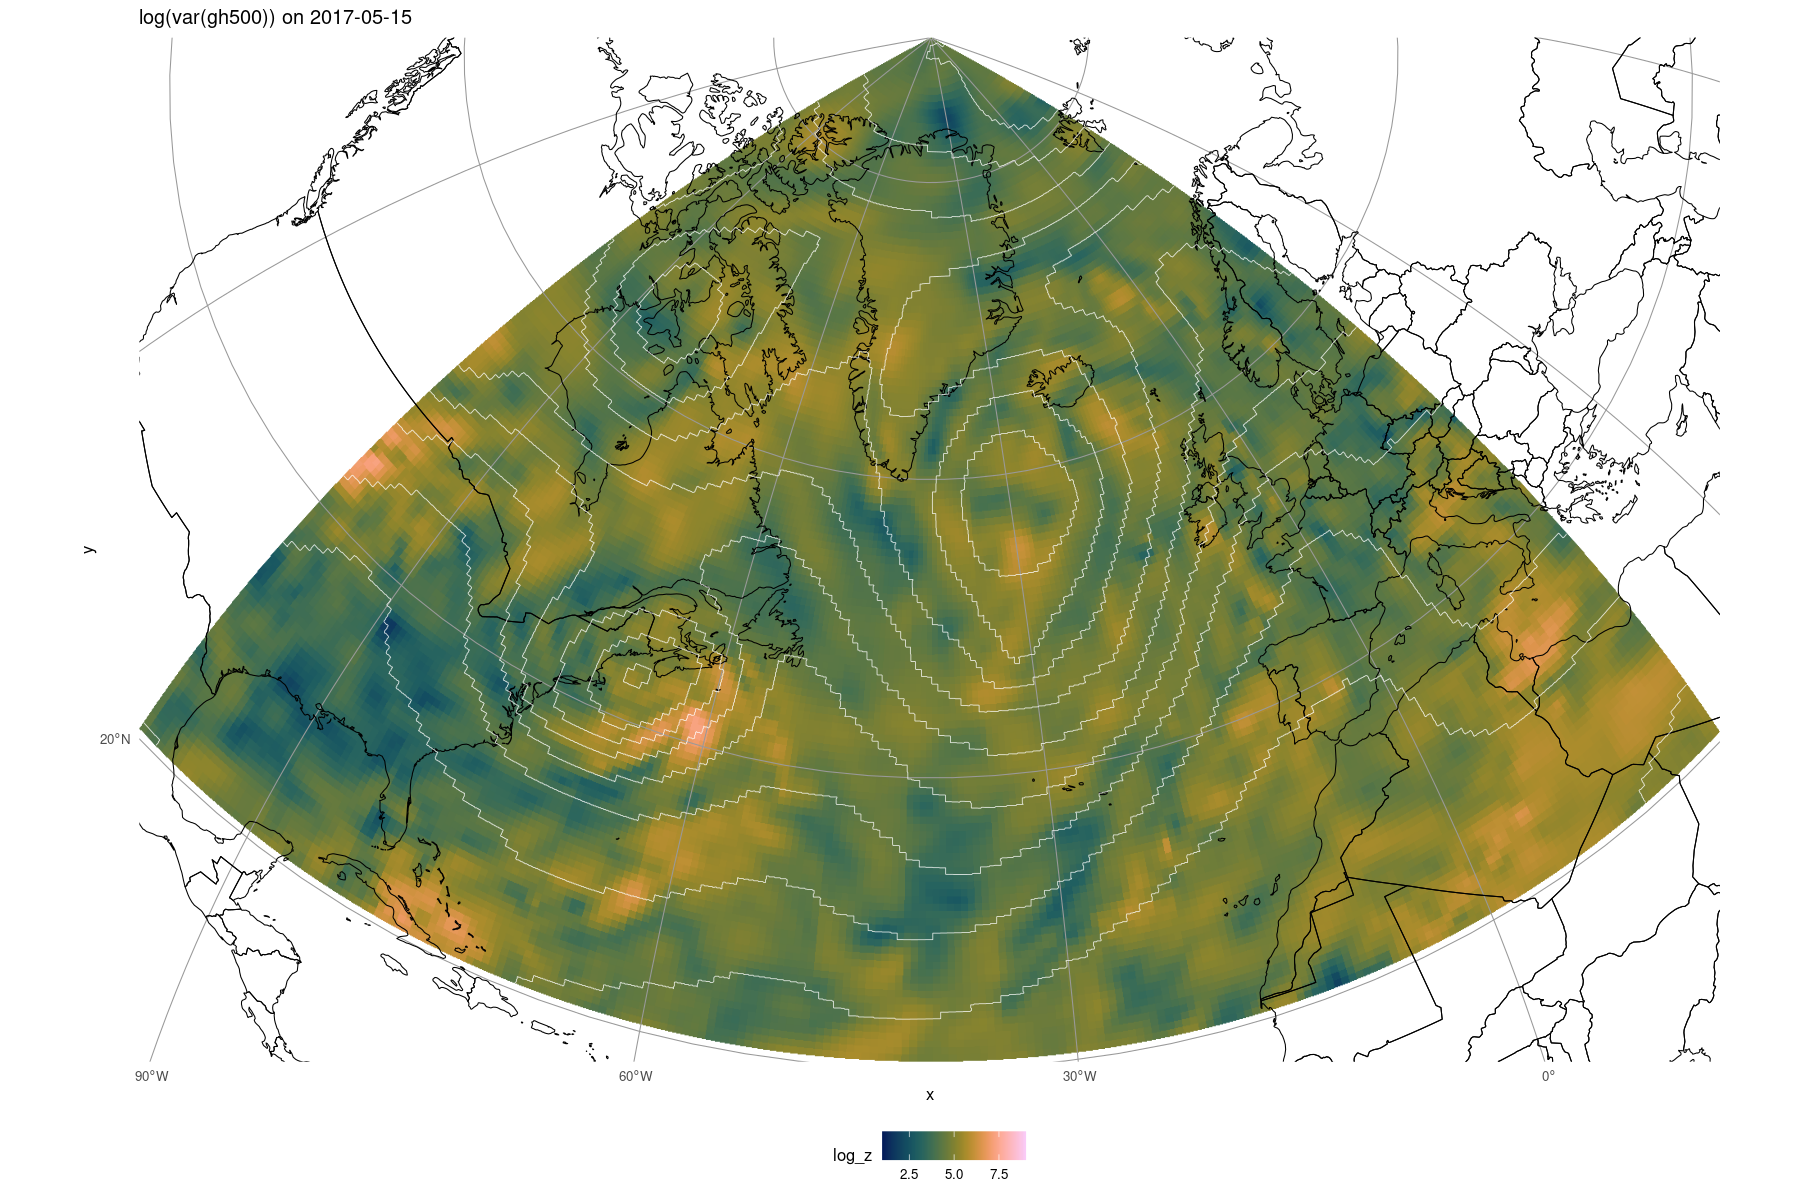

In [54]:
# Define start and end dates
start_date <- as.Date("2017-05-01")
# end_date <- as.Date("2017-05-01")

end_date <- as.Date("2017-05-15")

# Find indices corresponding to the desired time period
time_indices <- which(time >= start_date & time <= end_date)

# Loop through each time step in the subset
for (i in time_indices) {
    # Extract z data for the current time step (assuming z_data dimensions: [lon, lat, time])
    z_slice <- z_data[, , i]
    z_c_slice <- z_control[, , i]

    # Create a data frame with lon, lat, and the z values for this time step
    grid_df <- expand.grid(lon = lon, lat = lat)
    grid_df$log_z <- as.vector(log(z_slice))
    grid_df$z_cntrl <- as.vector(z_c_slice)

    # Generate a plot for the current time step using your plot_spatial function
    p <- plot_spatial(
        data = grid_df,
        var_name = "log_z",
        legend_name = "log_z",
        title = paste("log(var(gh500)) on", time[i]),
        clims = c(1, 9)
    )
    p <- add_contour(
        p, grid_df,
        contour_var = "z_cntrl",
        contour_color = "white",
        contour_linewidth = 0.25,
        CRS = CRS
    )
    # Create a filename for the current plot (e.g., "z_20170501.pdf")
    filename <- paste0("../figs/z_", format(time[i], "%Y%m%d"), ".pdf")

    # Save the plot using the provided save_plot function
    save_plot(p, filename, width = 12, height = 8)
}
p
